# The Battle of Neighborhoods （Week 2 - final report)

#### By: Pierre Shi

## 1. Introduction

### Look for a location to setup a Japanese Restaurant in Gyeonggi

Gyeonggi Province (Korean) is the most populous province in South Korea. Gyeonggi-do can be translated as "province surrounding Seoul". A group of Japanese investors want to setup some business in this province, but they do not know where to start, so they suggest to open a Japanese restaurant first to evaluate the local business environment. 

The question is where to setup such a business is the best choice. A successful startup could indicate a promising future while a failed investment may frustate the investors. Comparing the current restaurant setup, using c location data seems to be an idea. 

In this project, I am going to leverage the Foursquare location data together with the Gyeonggi cities' population and other restaurant information, to find out where the best place to maximize the success chance of this new Japanese restaurant. 

## 2. Data

### Description of the data source and method

1. The Wiki Data for the Korea cities will be used to provide the most recent population and density information.
2. Then using Foursquare data source, to extract the venues information is the next step.
3. Combining this information, we can analyze the K-means clusters for the population and current restaurant setup, to find the best city to start the business. 

In [2]:
## Install and import related packages
!conda install -c conda-forge folium=0.5.0 --yes
!pip install lxml
!pip install html5lib
!pip install requests
!pip install beautifulsoup4
!pip install tqdm
!pip install geopy

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup
from tqdm import tqdm
import seaborn as sns

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.1.5               |   py36h284efc9_0        11.3 MB  conda-forge
    pytz-2020.5                |     pyhd8ed1ab_0         244 KB  conda-forge
    toolz-0.11.1               |             py_0          46 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-

### 2.1 Download Data From Wiki

We get the South Korea city information from Wiki website

In [3]:
df_K = pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_in_South_Korea")[5]
df_K.head()

,City,Hangul,Hanja,Province,Population(2017),Area,Density,Founded
0,Andong,안동시,安東市,North Gyeongsang,168226,1521.26,110.6,1963-01-01
1,Ansan,안산시,安山市,Gyeonggi,689326,149.06,4624.5,1986-01-01
2,Anseong,안성시,安城市,Gyeonggi,182784,553.47,330.3,1998-04-01
3,Anyang,안양시,安養市,Gyeonggi,598392,58.46,10235.9,1973-07-01
4,Asan,아산시,牙山市,South Chungcheong,303043,542.15,559.0,1986-01-01


### 2.2 Data Cleanup

In [4]:
# Dropping not-needed columns, renaming columns, and replacing empty values
df_K.drop(columns=["Hangul", "Hanja", "Founded"], inplace = True)
df_K.columns = ["City", "Province", "Population", "Area", "Density"]
df_K.replace("*", 0, inplace=True)

# Correcting data types
df_K = df_K.astype({"Population":"float64", "Density":"float64"})
df_K.dtypes

City           object
Province       object
Population    float64
Area          float64
Density       float64
dtype: object

In [5]:
df_K

,City,Province,Population,Area,Density
0,Andong,North Gyeongsang,168226.0,1521.26,110.6
1,Ansan,Gyeonggi,689326.0,149.06,4624.5
2,Anseong,Gyeonggi,182784.0,553.47,330.3
3,Anyang,Gyeonggi,598392.0,58.46,10235.9
4,Asan,South Chungcheong,303043.0,542.15,559.0
...,...,...,...,...,...
80,Yeoju,Gyeonggi,111558.0,608.64,183.3
81,Yeongcheon,North Gyeongsang,100384.0,920.29,109.1
82,Yeongju,North Gyeongsang,109281.0,669.05,163.3
83,Yeosu,South Jeolla,288818.0,501.27,576.2


In fact we noticed that certain cities, they are not belonging to any Province, so the column name is changed to be "Region", and replace the "None" to be "Korea". 

In [6]:
df_K.rename(columns={'Province':'Region'}, inplace=True)
df_K['Region'] = np.where((df_K.Region == 'none'),'Korea',df_K.Region)

Here I will use the geolocator function to get the Lat and Long and add to our dataframe

In [7]:
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import json
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter

In [8]:
geolocator = Nominatim(user_agent="Korea_Explorer1")

Noticed there are two Gwangju in the city column, they are different places. One belongs to Gyeonggi the place we are investigating and the other not. We can check the location information as below. 

In [9]:
location1 = geolocator.geocode("Gwangju, Korea")
latitude = location1.latitude
longitude = location1.longitude
print(f"Coordinates of Gwangju, are {latitude}, {longitude}")
location2 = geolocator.geocode("Gwangju, Gyeonggi")
latitude = location2.latitude
longitude = location2.longitude
print(f"Coordinates of Gwangju of Province Gyeonggi are {latitude}, {longitude}")

Coordinates of Gwangju, are 35.1595775, 126.8515089
Coordinates of Gwangju of Province Gyeonggi are 37.4029557, 127.7886944


This shows the method we use to replace the "none" in the Province column with "Korea" should help us to assign the right lat and long value to the cities. 

In [10]:
# Getting coordinates of each city
tqdm.pandas()
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
coords = (df_K["City"]+ ", " + df_K["Region"]).progress_apply(geocode)
# Adding two new empty columns to dataframe
df_K["Latitude"] = np.nan
df_K["Longitude"] = np.nan
# Populating the Latitude and Longitude columns with data from coords
for index in df_K.index:
    df_K.at[index, 'Latitude'] = coords[index].latitude
    df_K.at[index, 'Longitude'] = coords[index].longitude

100%|██████████| 85/85 [01:24<00:00,  1.01it/s]


I will then display the map and verify the lat and long assignment results. 

In [11]:
! pip install folium==0.5.0
import folium # plotting library
print('Folium installed')
print('Libraries imported.')
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
from IPython.display import display_html
from math import sqrt, pi
df_K["Search Radius"] = df_K["Area"].apply(lambda x: round(sqrt(x/pi)*1000))
# Adding a new Search Radius column into dataframe, and re-ordering columns
# The new Search Radius will be used in the Foursquare API search query
df_K["Search Radius"] = df_K["Area"].apply(lambda x: round(sqrt(x/pi)*1000))
df_K = df_K[['City', 'Region', 'Area', 'Search Radius', 'Population', 'Density', 'Latitude', 'Longitude']]

# Visualising map using folium
# for loop used to add map markers for each city
map_K = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, region, name in zip(df_K['Latitude'], df_K['Longitude'], df_K['Region'], df_K['City']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_K)

map_K

Folium installed
Libraries imported.


Now we have the data verifyed, since only the part of the data in Gyeonggi is needed, I will just extract that part of the data and remove the unneeded ones

In [12]:
df_Gyeonggi = df_K.drop(df_K[df_K.Region != 'Gyeonggi'].index)
df_Gyeonggi.head()

,City,Region,Area,Search Radius,Population,Density,Latitude,Longitude
1,Ansan,Gyeonggi,149.06,6888,689326.0,4624.5,37.321715,126.830860
2,Anseong,Gyeonggi,553.47,13273,182784.0,330.3,37.002048,127.172084
3,Anyang,Gyeonggi,58.46,4314,598392.0,10235.9,37.393853,126.957060
6,Bucheon,Gyeonggi,53.40,4123,851245.0,15940.9,37.484110,126.782735
16,Dongducheon,Gyeonggi,95.66,5518,98062.0,1025.1,37.927826,127.054782


### 2.3 Get Data from Foursquare

Use my credential to get the venue data for the Gyeonggi cities

In [13]:
# use the following user ID and client Secret
CLIENT_ID = 'ZIO5LTYH2NFRAFS0EDV20VNBTXJZIMRLYC1AR0QQKOTLQUHF'
CLIENT_SECRET = 'SVRUJKAHEOEUHGIKDIZS5VHQNN5N2PVNOQGVKZJ3P5PYDDTF'
VERSION = '20180604'
LIMIT = 100

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Calling the user-defined function, and saving the results into a variable
df_Gyeonggi_venues = getNearbyVenues(names=df_Gyeonggi['City'],latitudes=df_Gyeonggi['Latitude'],longitudes=df_Gyeonggi['Longitude'],radius=df_Gyeonggi['Search Radius'])

Ansan
Anseong
Anyang
Bucheon
Dongducheon
Gimpo
Goyang
Gunpo
Guri
Gwacheon
Gwangju
Gwangmyeong
Hanam
Hwaseong
Icheon
Namyangju
Osan
Paju
Pocheon
Pyeongtaek
Seongnam
Siheung
Suwon
Uijeongbu
Uiwang
Yangju
Yeoju
Yongin


In [15]:
print(df_Gyeonggi_venues.shape)
df_Gyeonggi_venues.head()

(2177, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ansan,37.321715,126.83086,Starbucks (스타벅스),37.316738,126.837578,Coffee Shop
1,Ansan,37.321715,126.83086,경기도미술관,37.325320,126.814133,Art Gallery
2,Ansan,37.321715,126.83086,Starbucks (스타벅스),37.300614,126.838058,Coffee Shop
3,Ansan,37.321715,126.83086,E-Mart (이마트),37.302689,126.813207,Supermarket
4,Ansan,37.321715,126.83086,일동토종순대감자탕,37.309712,126.869358,Korean Restaurant


In [16]:
print("Number of unique venue categories in Gyeonggi of Korea:{}".format(len(df_Gyeonggi_venues["Venue Category"].unique())))

Number of unique venue categories in Gyeonggi of Korea:195


# 3. Methodology

### 3.1 Data Exploration

In [17]:
df_Gyeonggi_venues["Venue Category"].unique()

array(['Coffee Shop', 'Art Gallery', 'Supermarket', 'Korean Restaurant',
       'Park', 'Department Store', 'Multiplex', 'Public Art',
       'Performing Arts Venue', 'Golf Course', 'Burger Joint',
       'Seafood Restaurant', 'Reservoir', 'Convenience Store',
       'BBQ Joint', 'Steakhouse', 'Ice Cream Shop', 'Stadium',
       'Big Box Store', 'Japanese Restaurant', 'Chinese Restaurant',
       'Donut Shop', 'Fast Food Restaurant', 'Bakery', 'Field',
       'Bus Stop', 'Indian Restaurant', 'Korean BBQ Restaurant',
       'Clothing Store', 'Thai Restaurant', 'Gym', 'Arts & Entertainment',
       'Theme Park', 'Music Venue', 'Rest Area', 'American Restaurant',
       'Noodle House', 'Italian Restaurant', 'Train Station',
       'New American Restaurant', 'Movie Theater', 'Metro Station',
       'Café', 'Hockey Arena', 'Pool', 'Fried Chicken Joint',
       'Sandwich Place', 'Bath House', 'Market', 'Samgyetang Restaurant',
       'Farmers Market', 'Vietnamese Restaurant', 'Sculpture Gard

In [18]:
df_Gyeonggi_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Ansan,46,46,46,46,46,46
Anseong,76,76,76,76,76,76
Anyang,100,100,100,100,100,100
Bucheon,93,93,93,93,93,93
Dongducheon,29,29,29,29,29,29
Gimpo,100,100,100,100,100,100
Goyang,100,100,100,100,100,100
Gunpo,80,80,80,80,80,80
Guri,66,66,66,66,66,66


In [19]:
# one hot encoding
Gyeonggi_onehot = pd.get_dummies(df_Gyeonggi_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
Gyeonggi_onehot.insert(loc = 0, column = 'City', value = df_Gyeonggi_venues['City'])

# summing one-hot values
Gyeonggi_grouped_sum = Gyeonggi_onehot.groupby('City').sum().reset_index()

In [20]:
# Showing the top 5 venue categories for each City
num_top_venues = 5
for area in Gyeonggi_grouped_sum['City']:
    print("----"+area+"----")
    temp = Gyeonggi_grouped_sum[Gyeonggi_grouped_sum['City'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ansan----
               venue  freq
0        Coffee Shop   9.0
1     Ice Cream Shop   5.0
2  Korean Restaurant   4.0
3          Multiplex   2.0
4          BBQ Joint   2.0


----Anseong----
                  venue  freq
0     Korean Restaurant  16.0
1  Fast Food Restaurant   7.0
2             Rest Area   6.0
3           Coffee Shop   6.0
4           Golf Course   5.0


----Anyang----
               venue  freq
0        Coffee Shop  19.0
1  Korean Restaurant  13.0
2          BBQ Joint   6.0
3     Ice Cream Shop   5.0
4             Bakery   4.0


----Bucheon----
                  venue  freq
0     Korean Restaurant  13.0
1           Coffee Shop  11.0
2        Ice Cream Shop   8.0
3                Bakery   8.0
4  Fast Food Restaurant   5.0


----Dongducheon----
                  venue  freq
0     Korean Restaurant   6.0
1   American Restaurant   3.0
2  Fast Food Restaurant   3.0
3           Coffee Shop   2.0
4                   Spa   1.0


----Gimpo----
               venue  freq
0   

This information is useful because it provides a basic idea of which venues are popular in each city. 

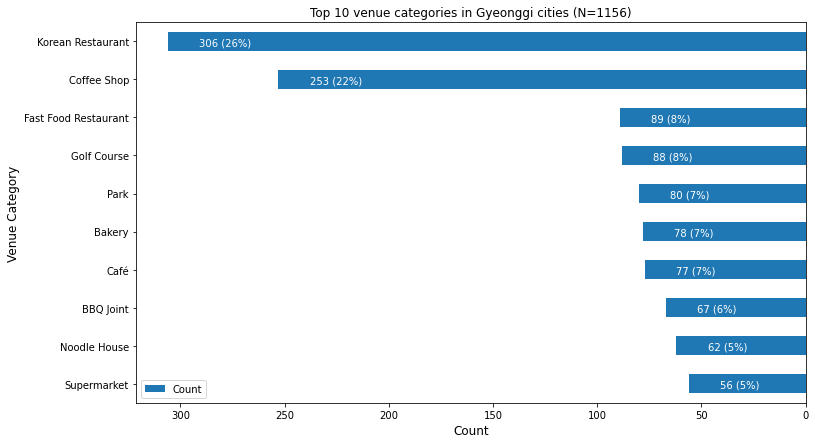

In [21]:
# Getting the top 10 venue categories in all Cities combined for Gyeonggi
venue_count = df_Gyeonggi_venues[['City', 'Venue Category']].groupby('Venue Category').count()
venue_top10 = venue_count.sort_values(by='City', ascending=False).rename(columns={'City':'Count'}).head(10)
venue_top10 = venue_top10.sort_values('Count',ascending=True)
venue_top10.reset_index(drop=False, inplace=True)
# Plotting bar chart
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  # plotting library
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

venue_top10.plot(kind='barh', x='Venue Category', y='Count', figsize=(12,7))
plt.xlabel('Count', fontsize=12)
plt.ylabel('Venue Category', fontsize=12)
plt.title(f'Top 10 venue categories in Gyeonggi cities (N={venue_top10.Count.sum()})', fontsize=12)

for index, count in zip (venue_top10.index, venue_top10.Count):
    plt.annotate(f'{count} ({round(count/venue_top10.Count.sum()*100)}%)', xy=(count - 15, index-0.1), color="white")
plt.gca().invert_xaxis()
plt.show()

This graph shows that Korea restaurant and Coffee shop have the biggest quantities in Korea, which makes sense. Noodle House is one type of Japanese restaurant which has a position in the top 10 list.

### 3.2 Correlation analysis

There are three "objects" we are considering as most related to the analysis: 
- we need to know the relationship between Population and Japanese Restaurant, hopefully it is strong
- we also need to consider the other restaurants in the local area

Let us check the correlation between the number of Japanese restaurants and the population. 

In [22]:
# Calculating pearson correlations of all venue categories with density
correlation = Gyeonggi_grouped_sum.corrwith(df_Gyeonggi["Population"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 15 venue categories with population density: \n{correlation[:15]} \n')

Pearson correlation of top 15 venue categories with population density: 
Art Gallery            0.795832
Shopping Mall          0.688468
Mountain               0.649587
Resort                 0.635153
Baseball Field         0.635153
Vacation Rental        0.635153
Noodle House           0.565403
Botanical Garden       0.563034
Italian Restaurant     0.482185
Steakhouse             0.481409
Thai Restaurant        0.472376
American Restaurant    0.455824
Dessert Shop           0.437389
Supermarket            0.419478
Sake Bar               0.406836
dtype: float64 



The result is interesting. It does not show Japanese restaurant on the top 10 list, probably because sometimes they are categorized as "Ramen", "Sushi Shop" or "Noodle House". In fact the "Noodle House" gets higher than even the "Korean Restaurant" may indicate a medium strong correlation of the Japanese restaurant and Local population. 
This needs to be further confirmed. 

Our objective is to find the most suitable city to setup the Japanese. Therefore the local competitor information needs to be analyzed together with the market size. For this purpose, the existing venues are extracted, and those competitor quantity is counted. Then we will use the K-means clustering method to identify the best fit. 

The number of all restaurant quantity is an useful information when analyze the business environment. Therefore I will extract all the venues been in the venue category containing the key word "Restaurant". 

In [23]:
Gyeonggi_Restaurant = df_Gyeonggi_venues[(df_Gyeonggi_venues['Venue Category'].str.contains('Restaurant', regex=False))].groupby(['City']).count()
Gyeonggi_Restaurant.drop(['City Latitude', 'City Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
Gyeonggi_Restaurant.rename(columns = {'Venue Category':'Number of Restaurants'}, inplace=True)
Gyeonggi_Restaurant.head()

,Number of Restaurants
City,
Ansan,10
Anseong,32
Anyang,27
Bucheon,29
Dongducheon,13


Then we will extract the competitor information: those in the venue category containing "Japanese", but also those having key words like "Sushi", "Ramen", "Noodle", "Soba" and "Noodle". All these can be potential competitors. 

In [24]:
Gyeonggi_Jp = df_Gyeonggi_venues[(df_Gyeonggi_venues['Venue Category'].str.contains('Japanese', regex=False)) |
                 (df_Gyeonggi_venues['Venue Category'].str.contains('Sushi', regex=False)) |
                 (df_Gyeonggi_venues['Venue Category'].str.contains('Ramen', regex=False)) |
                 (df_Gyeonggi_venues['Venue Category'].str.contains('Noodle', regex=False))|
                 (df_Gyeonggi_venues['Venue Category'].str.contains('Soba', regex=False))].groupby(['City']).count()
Gyeonggi_Jp.drop(['City Latitude', 'City Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
Gyeonggi_Jp.rename(columns = {'Venue Category':'Number of Japanese Restaurants'}, inplace=True)
Gyeonggi_Jp.head(5)

,Number of Japanese Restaurants
City,
Ansan,1
Anseong,1
Anyang,6
Bucheon,6
Gimpo,9


In [25]:
Gyeonggi_Jp = df_Gyeonggi.join(Gyeonggi_Jp, on='City')
Gyeonggi_Jp = Gyeonggi_Jp.join(Gyeonggi_Restaurant, on='City')
Gyeonggi_Jp.head()

,City,Region,Area,Search Radius,Population,Density,Latitude,Longitude,Number of Japanese Restaurants,Number of Restaurants
1,Ansan,Gyeonggi,149.06,6888,689326.0,4624.5,37.321715,126.830860,1.0,10
2,Anseong,Gyeonggi,553.47,13273,182784.0,330.3,37.002048,127.172084,1.0,32
3,Anyang,Gyeonggi,58.46,4314,598392.0,10235.9,37.393853,126.957060,6.0,27
6,Bucheon,Gyeonggi,53.40,4123,851245.0,15940.9,37.484110,126.782735,6.0,29
16,Dongducheon,Gyeonggi,95.66,5518,98062.0,1025.1,37.927826,127.054782,NaN,13


As seen there are sometimes "NaN" values, they need to be cleaned up. 

In [26]:
Gyeonggi_Jp = Gyeonggi_Jp.fillna(0)
#df[['Number of restaurants', 'Number of beer restaurants']] = df[['Number of restaurants', 'Number of beer restaurants']].astype('int64')
Gyeonggi_Jp.head(10)

,City,Region,Area,Search Radius,Population,Density,Latitude,Longitude,Number of Japanese Restaurants,Number of Restaurants
1,Ansan,Gyeonggi,149.06,6888,689326.0,4624.5,37.321715,126.830860,1.0,10
2,Anseong,Gyeonggi,553.47,13273,182784.0,330.3,37.002048,127.172084,1.0,32
3,Anyang,Gyeonggi,58.46,4314,598392.0,10235.9,37.393853,126.957060,6.0,27
6,Bucheon,Gyeonggi,53.40,4123,851245.0,15940.9,37.484110,126.782735,6.0,29
16,Dongducheon,Gyeonggi,95.66,5518,98062.0,1025.1,37.927826,127.054782,0.0,13
23,Gimpo,Gyeonggi,276.64,9384,364808.0,1318.7,37.609533,126.791427,9.0,24
25,Goyang,Gyeonggi,267.31,9224,1040648.0,3893.0,37.676485,126.743154,8.0,27
27,Gunpo,Gyeonggi,36.36,3402,284735.0,7831.0,37.361523,126.934903,3.0,14
29,Guri,Gyeonggi,33.30,3256,194298.0,5834.8,37.603252,127.143375,0.0,22
30,Gwacheon,Gyeonggi,35.86,3379,62929.0,1754.9,37.433109,126.996133,4.0,27


In [27]:
Gyeonggi_Jp.describe()

,Area,Search Radius,Population,Density,Latitude,Longitude,Number of Japanese Restaurants,Number of Restaurants
count,28.000000,28.000000,2.800000e+01,28.000000,28.000000,28.000000,28.000000,28.000000
mean,279.962857,8434.250000,4.467390e+05,3739.282143,37.449186,127.063794,3.214286,22.178571
std,249.784739,4318.023739,3.213880e+05,3902.512448,0.238317,0.246084,2.587107,9.071949
min,33.300000,3256.000000,6.292900e+04,183.300000,36.992497,126.743154,0.000000,7.000000
25%,57.345000,4272.000000,2.030572e+05,893.875000,37.307347,126.871339,1.000000,13.750000
50%,145.440000,6803.500000,3.519395e+05,2021.900000,37.409668,127.045393,3.000000,23.000000
75%,476.677500,12311.250000,6.489192e+05,5491.825000,37.616134,127.173702,5.000000,29.000000
max,826.500000,16220.000000,1.194276e+06,15940.900000,37.927826,127.788694,9.000000,41.000000


In [28]:
# create map using latitude and longitude values
map_Gyeonggi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, City in zip(Gyeonggi_Jp['Latitude'], Gyeonggi_Jp['Longitude'], Gyeonggi_Jp['City']):
    label = '{}'.format(City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Gyeonggi)  
    
map_Gyeonggi

Now we will make a bar chart to compare the quantity of "restaurant" and "Japanese restaurant". This gives a basic idea of the situation but a further detailed analysis using clustering method will be needed. 

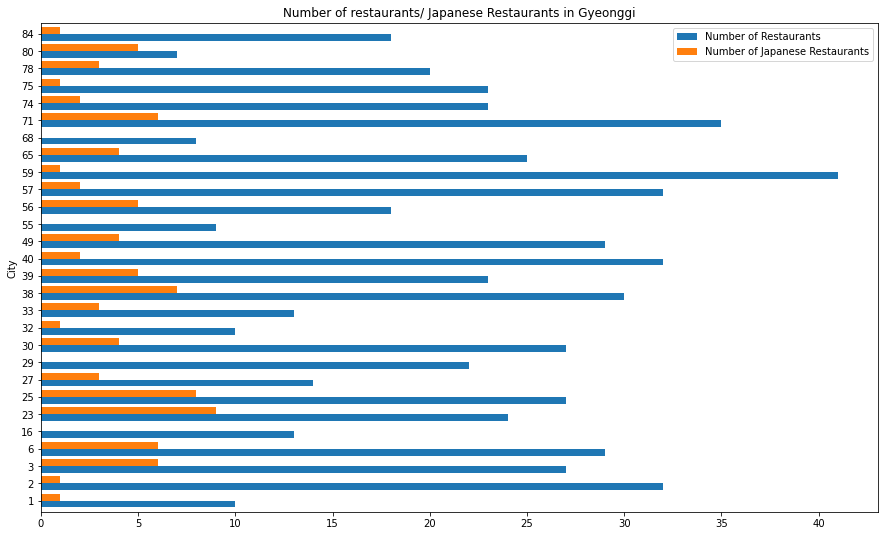

In [29]:
Gyeonggi_Jp[['Number of Restaurants', 'Number of Japanese Restaurants']].plot(kind='barh', figsize=(15, 9), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('City') # add y-label to the plot
plt.title('Number of restaurants/ Japanese Restaurants in Gyeonggi') # add title to the plot
plt.yticks()
plt.show()

### Analyzing the relationship of population and Japanese Restaurant

Our "guess" that there is a correlation between the population and quantity of restaurants, this needs to be verified. 

First let us check the distribution of these two objects. 

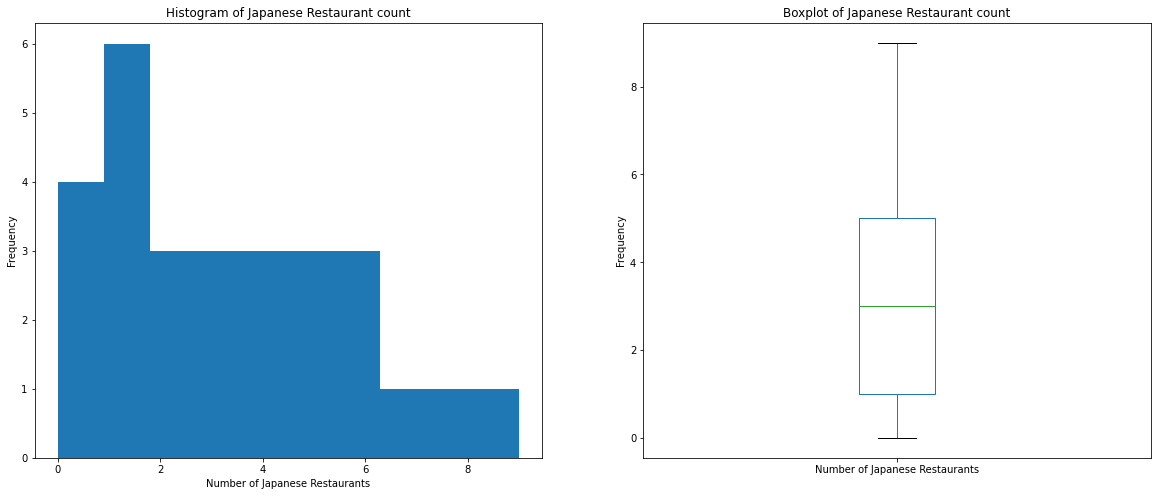

In [30]:
# Visualising the distribution of Japanese Restaurants
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Histogram
Gyeonggi_Jp['Number of Japanese Restaurants'].plot(kind='hist', title='Histogram of Japanese Restaurant count', figsize=(20,8), ax=ax0)
ax0.set_xlabel('Number of Japanese Restaurants')

# Subplot 2: Boxplot
Gyeonggi_Jp['Number of Japanese Restaurants'].plot(kind='box', title='Boxplot of Japanese Restaurant count', figsize=(20,8), ax=ax1)
ax1.set_ylabel('Frequency')

plt.show()

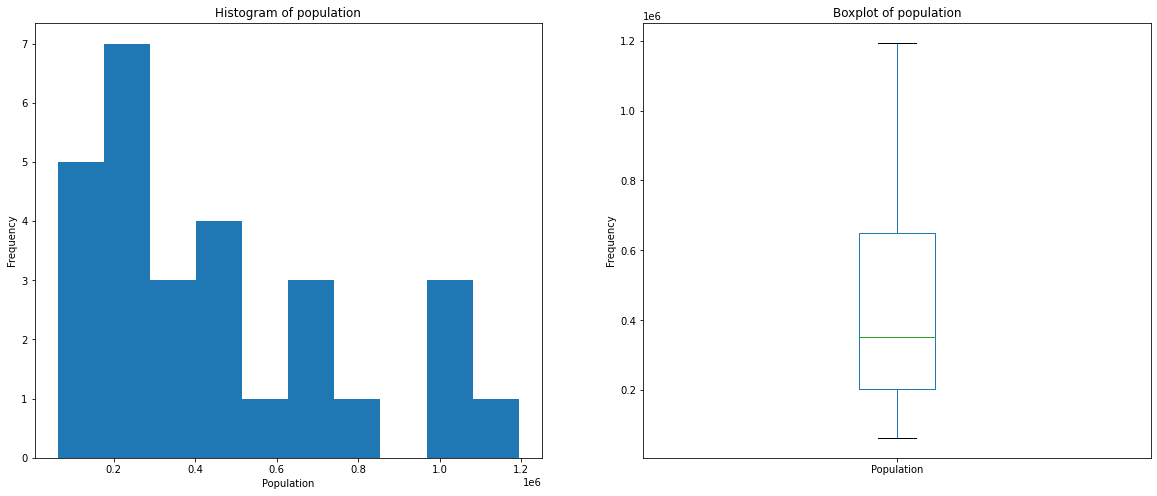

In [31]:
# Visualising the distribution of Density
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Histogram
Gyeonggi_Jp['Population'].plot(kind='hist', title='Histogram of population', figsize=(20, 8), ax=ax0)
ax0.set_xlabel('Population')

# Subplot 2: Boxplot
Gyeonggi_Jp['Population'].plot(kind='box', title='Boxplot of population', figsize=(20,8), ax=ax1)
ax1.set_ylabel('Frequency')

plt.show()

Now setup a scatter plot to find the relationship between these two. 

In [33]:
scaler = StandardScaler()
scaled = scaler.fit_transform(Gyeonggi_Jp[['Population', 'Number of Japanese Restaurants']])
scaled_df = pd.DataFrame(scaled, columns=['Population_norm', 'Count_norm'])

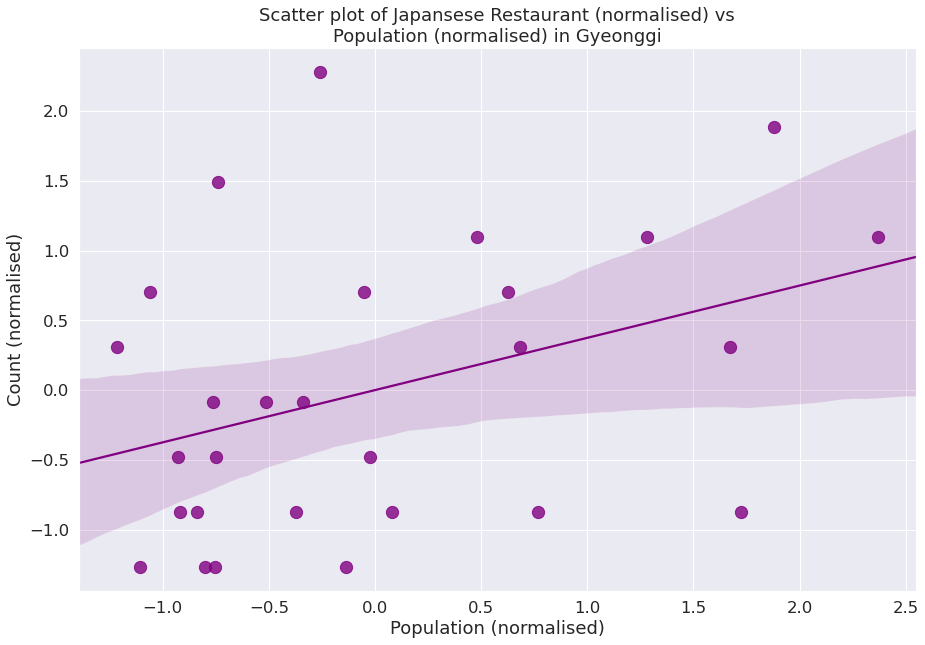

In [34]:
# Plotting scatter plot between Japanese Restaurant and Population
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.regplot(x='Population_norm', y='Count_norm', data=scaled_df, color='purple', scatter_kws={'s': 150})
plt.xlabel('Population (normalised)')
plt.ylabel('Count (normalised)')
plt.title('Scatter plot of Japansese Restaurant (normalised) vs\nPopulation (normalised) in Gyeonggi')
sns.set_style('ticks')
plt.show()

The above observation suggests:
The positive correlative relationship between "Population" and "Japanese Restaurant" exists, but it is not very strong. There exists some "Outiers". 
This means we need to further analyze the data using clustering method to find where the most suitable place should be. 

### 3.3 Cluster the data: population and Japanese Restaurant

Normalize the data as below. 

In [35]:
scaled

array([[ 0.76866143, -0.87159841],
       [-0.83636786, -0.87159841],
       [ 0.4805279 ,  1.09652704],
       [ 1.28171808,  1.09652704],
       [-1.10481804, -1.2652235 ],
       [-0.2596065 ,  2.27740231],
       [ 1.88186054,  1.88377722],
       [-0.51332586, -0.08434823],
       [-0.7998846 , -1.2652235 ],
       [-1.21614049,  0.30927686],
       [-0.37325787, -0.87159841],
       [-0.34115678, -0.08434823],
       [-0.74053671,  1.49015213],
       [ 0.6266194 ,  0.70290195],
       [-0.74834097, -0.47797332],
       [ 0.6826561 ,  0.30927686],
       [-0.75370224, -1.2652235 ],
       [-0.04975959,  0.70290195],
       [-0.92636563, -0.47797332],
       [ 0.08048891, -0.87159841],
       [ 1.67307194,  0.30927686],
       [-0.13733021, -1.2652235 ],
       [ 2.36864631,  1.09652704],
       [-0.02530433, -0.47797332],
       [-0.91993654, -0.87159841],
       [-0.76287851, -0.08434823],
       [-1.06205461,  0.70290195],
       [ 1.72651672, -0.87159841]])

Use K-means method to run the analysis

In [36]:
# run k-means clustering
k_means = KMeans(n_clusters=4, random_state=0, n_init=12).fit(scaled)

# saving the labels and cluster centers into variables
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

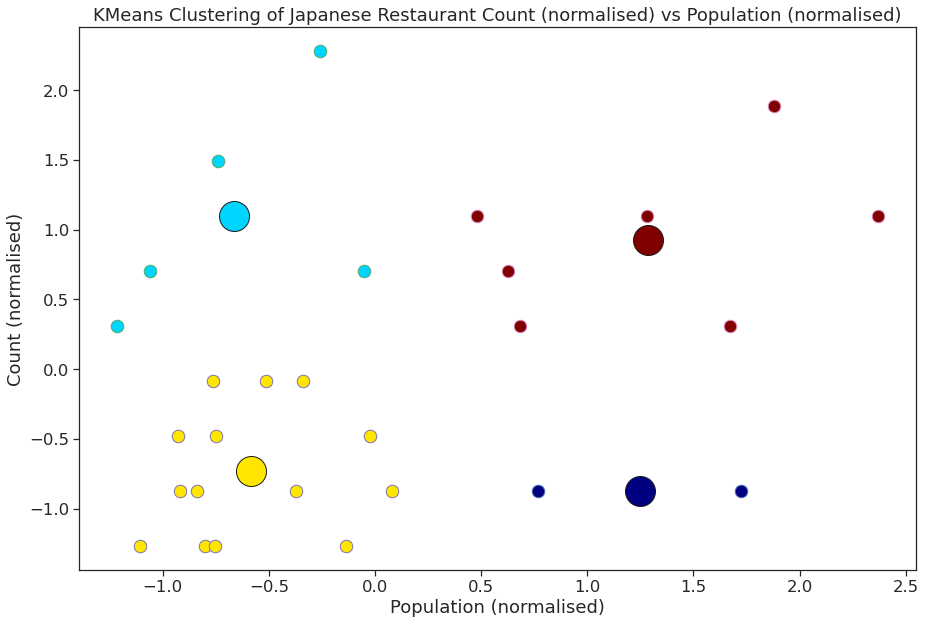

In [37]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15,10))

# Colours uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colours = plt.cm.jet(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# Setting font size
plt.rcParams.update({'font.size': 14})

# For loop that plots the data points and centroids.
for k, col in zip(range(len(k_means_cluster_centers)), colours):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(scaled[my_members, 0], scaled[my_members, 1], 'o', markerfacecolor=col, marker='.', markersize=25)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=30)

ax.set_title('KMeans Clustering of Japanese Restaurant Count (normalised) vs Population (normalised)')
ax.set_xlabel('Population (normalised)')
ax.set_ylabel('Count (normalised)')
plt.show()

As shown, there are 4 different clusters and confirms the population and quantity of Japanese Restaurants exist, but not very clear. In fact, it separates the cities into 4 groups: 
1. Group 1, yellow bubbles, with lower population and low quantity of competitors
2. Group 2, light blue bubbles, with lower population and high quantity of competitors
3. Group 3, red bubbles, with high population and high quantity of competitors
4. Group 4, dark blue bubbles, with high population and low quantity of competitors, which is what we most interested of

Label the cities using the cluster labels.

In [38]:
Gyeonggi_Jp_labelled = Gyeonggi_Jp
Gyeonggi_Jp_labelled.insert(loc=(len(Gyeonggi_Jp_labelled.columns)), column='Cluster Label', value=k_means_labels)
Gyeonggi_Jp_labelled.head()

,City,Region,Area,Search Radius,Population,Density,Latitude,Longitude,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
1,Ansan,Gyeonggi,149.06,6888,689326.0,4624.5,37.321715,126.830860,1.0,10,0
2,Anseong,Gyeonggi,553.47,13273,182784.0,330.3,37.002048,127.172084,1.0,32,2
3,Anyang,Gyeonggi,58.46,4314,598392.0,10235.9,37.393853,126.957060,6.0,27,3
6,Bucheon,Gyeonggi,53.40,4123,851245.0,15940.9,37.484110,126.782735,6.0,29,3
16,Dongducheon,Gyeonggi,95.66,5518,98062.0,1025.1,37.927826,127.054782,0.0,13,2


In [39]:
Gyeonggi_Jp_labelled['Cluster Label'].value_counts()

2    14
3     7
1     5
0     2
Name: Cluster Label, dtype: int64

As analyzed there are 4 clusters we have generated. 

In [40]:
cluster0 = Gyeonggi_Jp_labelled[Gyeonggi_Jp_labelled['Cluster Label'] == 0].drop(columns=['Latitude', 'Longitude'])
print('Cluster 0 (n={}) are cities with low numbers of Japanese Restaurant per City (range: {} - {})\n\
with High Population (median population={})'.format(cluster0.count()[0], 
                                                    cluster0['Number of Japanese Restaurants'].min(),
                                                    cluster0['Number of Japanese Restaurants'].max(),
                                                    cluster0['Population'].median()))
cluster0.sort_values(by='Number of Japanese Restaurants', ascending=False)

Cluster 0 (n=2) are cities with low numbers of Japanese Restaurant per City (range: 1.0 - 1.0)
with High Population (median population=840474.0)


,City,Region,Area,Search Radius,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
1,Ansan,Gyeonggi,149.06,6888,689326.0,4624.5,1.0,10,0
84,Yongin,Gyeonggi,591.36,13720,991622.0,1676.8,1.0,18,0


These two cities are attractive, because they meet our interest: with high population and very low number of Japanese restaurants. 

In [41]:
cluster1 = Gyeonggi_Jp_labelled[Gyeonggi_Jp_labelled['Cluster Label'] == 1].drop(columns=['Latitude', 'Longitude'])
print('Cluster 1 (n={}) are cities with high numbers of Japanese Restaurant per City (range: {} - {})\n\
with Low Population (median population={})'.format(cluster1.count()[0], 
                                                   cluster1['Number of Japanese Restaurants'].min(),
                                                   cluster1['Number of Japanese Restaurants'].max(),
                                                   cluster1['Population'].median()))
cluster1.sort_values(by='Number of Japanese Restaurants', ascending=False)

Cluster 1 (n=5) are cities with high numbers of Japanese Restaurant per City (range: 4.0 - 9.0)
with Low Population (median population=213028.0)


,City,Region,Area,Search Radius,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
23,Gimpo,Gyeonggi,276.64,9384,364808.0,1318.7,9.0,24,1
38,Hanam,Gyeonggi,93.07,5443,213028.0,2288.9,7.0,30,1
56,Paju,Gyeonggi,672.57,14632,431035.0,640.9,5.0,18,1
80,Yeoju,Gyeonggi,608.64,13919,111558.0,183.3,5.0,7,1
30,Gwacheon,Gyeonggi,35.86,3379,62929.0,1754.9,4.0,27,1


In [42]:
cluster2 = Gyeonggi_Jp_labelled[Gyeonggi_Jp_labelled['Cluster Label'] == 2].drop(columns=['Latitude', 'Longitude'])
print('Cluster 2 (n={}) are cities with low numbers of Japanese Restaurant per City (range: {} - {})\n\
with low Population (median population={})'.format(cluster2.count()[0], 
                                                    cluster2['Number of Japanese Restaurants'].min(),
                                                    cluster2['Number of Japanese Restaurants'].max(),
                                                    cluster2['Population'].median()))
cluster2.sort_values(by='Number of Japanese Restaurants', ascending=False)

Cluster 2 (n=14) are cities with low numbers of Japanese Restaurant per City (range: 0.0 - 3.0)
with low Population (median population=209719.0)


,City,Region,Area,Search Radius,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
27,Gunpo,Gyeonggi,36.36,3402,284735.0,7831.0,3.0,14,2
33,Gwangmyeong,Gyeonggi,38.50,3501,339071.0,8807.0,3.0,13,2
78,Yangju,Gyeonggi,309.77,9930,205977.0,664.9,3.0,20,2
40,Icheon,Gyeonggi,531.09,13002,210565.0,396.5,2.0,32,2
57,Pocheon,Gyeonggi,826.50,16220,154381.0,186.8,2.0,32,2
74,Uijeongbu,Gyeonggi,81.59,5096,438753.0,5377.5,2.0,23,2
2,Anseong,Gyeonggi,553.47,13273,182784.0,330.3,1.0,32,2
32,Gwangju,Gyeonggi,430.96,11712,328940.0,763.3,1.0,10,2
59,Pyeongtaek,Gyeonggi,454.62,12030,472141.0,1038.5,1.0,41,2
75,Uiwang,Gyeonggi,54.00,4146,156410.0,2896.5,1.0,23,2


In this list, we found the index 68 (Siheung) can also be considered, its population is slightly lower as compared to cluster 1 cities, but still as "medium" and it does not have any Japanese restaurants. 

In [43]:
cluster3 = Gyeonggi_Jp_labelled[Gyeonggi_Jp_labelled['Cluster Label'] == 3].drop(columns=['Latitude', 'Longitude'])
print('Cluster 3 (n={}) are cities with high numbers of Japanese Restaurant per City (range: {} - {})\n\
with high Population (median population={})'.format(cluster3.count()[0], 
                                                    cluster3['Number of Japanese Restaurants'].min(),
                                                    cluster3['Number of Japanese Restaurants'].max(),
                                                    cluster3['Population'].median()))
cluster3.sort_values(by='Number of Japanese Restaurants', ascending=False)

Cluster 3 (n=7) are cities with high numbers of Japanese Restaurant per City (range: 4.0 - 8.0)
with high Population (median population=851245.0)


,City,Region,Area,Search Radius,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
25,Goyang,Gyeonggi,267.31,9224,1040648.0,3893.0,8.0,27,3
3,Anyang,Gyeonggi,58.46,4314,598392.0,10235.9,6.0,27,3
6,Bucheon,Gyeonggi,53.40,4123,851245.0,15940.9,6.0,29,3
71,Suwon,Gyeonggi,121.09,6208,1194276.0,9862.7,6.0,35,3
39,Hwaseong,Gyeonggi,687.54,14794,644498.0,937.4,5.0,23,3
49,Namyangju,Gyeonggi,458.54,12081,662183.0,1444.1,4.0,29,3
65,Seongnam,Gyeonggi,141.82,6719,974755.0,6873.2,4.0,25,3


####  Result from this clustering analysis:

The clustering result suggests, the cluster 0, is the most interesting group of cities which should be put into priority of setting up the restaurant. These 2 cities (together with 1 city found in cluster 2) have a high population but very low quantity of competitors. 
However, because the relation between Population and Japanese Restaurant, although exists, does has outiers, so we are going to further explore other evidence to support the finding.  

### 3.4 "Density" analysis

The density analysis is to investigate the relationship between two densities, the population density (in terms of area space) and the restaurant density (based on population)

It is assumed that a high population density, may indicate more visits to restaurants. We hope this analysis can strengthen the conclusion we got from the last clustering investigation. 

In [44]:
Gyeonggi_Jp.head()

,City,Region,Area,Search Radius,Population,Density,Latitude,Longitude,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
1,Ansan,Gyeonggi,149.06,6888,689326.0,4624.5,37.321715,126.830860,1.0,10,0
2,Anseong,Gyeonggi,553.47,13273,182784.0,330.3,37.002048,127.172084,1.0,32,2
3,Anyang,Gyeonggi,58.46,4314,598392.0,10235.9,37.393853,126.957060,6.0,27,3
6,Bucheon,Gyeonggi,53.40,4123,851245.0,15940.9,37.484110,126.782735,6.0,29,3
16,Dongducheon,Gyeonggi,95.66,5518,98062.0,1025.1,37.927826,127.054782,0.0,13,2


In [45]:
Gyeonggi_Jp_2 = Gyeonggi_Jp.drop(['Region', 'Area','Search Radius', 'Latitude', 'Longitude'],axis = 1)

In [46]:
df_clusters = Gyeonggi_Jp_2.drop(['City','Cluster Label'],axis = 1)

The next step is to convert the number of restaurants into density of restaurants. This is partly because in the above part, the relation between population and restaurants has been fully explored. 

In [47]:
df_clusters.head()

,Population,Density,Number of Japanese Restaurants,Number of Restaurants
1,689326.0,4624.5,1.0,10
2,182784.0,330.3,1.0,32
3,598392.0,10235.9,6.0,27
6,851245.0,15940.9,6.0,29
16,98062.0,1025.1,0.0,13


In [48]:
df_clusters['Number of restaurants per 1000 people'] = df_clusters['Number of Restaurants']/(df_clusters['Population']/1000)
df_clusters['Number of Japanese restaurants per 1000 people'] = df_clusters['Number of Japanese Restaurants']/(df_clusters['Population']/1000)
df_clusters.head()

,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Number of restaurants per 1000 people,Number of Japanese restaurants per 1000 people
1,689326.0,4624.5,1.0,10,0.014507,0.001451
2,182784.0,330.3,1.0,32,0.175070,0.005471
3,598392.0,10235.9,6.0,27,0.045121,0.010027
6,851245.0,15940.9,6.0,29,0.034068,0.007048
16,98062.0,1025.1,0.0,13,0.132569,0.000000


In the following cluster analysis, we focus on the Population Density and Restaurant Density

In [49]:
df_clusters = df_clusters.drop(['Population', 'Number of Restaurants', 'Number of Japanese Restaurants', 'Number of Japanese restaurants per 1000 people'], axis = 1)
df_clusters.head()

,Density,Number of restaurants per 1000 people
1,4624.5,0.014507
2,330.3,0.175070
3,10235.9,0.045121
6,15940.9,0.034068
16,1025.1,0.132569


Normalize the data.

In [50]:
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[ 0.23099523, -0.82388241],
       [-0.88956475,  1.07504418],
       [ 1.695275  , -0.46182079],
       [ 3.18397945, -0.59254304],
       [-0.70825855,  0.57240087],
       [-0.63164442, -0.21739776],
       [ 0.04011226, -0.68860368],
       [ 1.0677228 , -0.41395115],
       [ 0.54681976,  0.34366061],
       [-0.5178192 ,  4.07883985],
       [-0.77657456, -0.63591222],
       [ 1.32240738, -0.5420159 ],
       [-0.37847333,  0.67005802],
       [-0.73114363, -0.57339635],
       [-0.87229003,  0.80187235],
       [-0.59892162, -0.47750749],
       [ 0.29891981, -0.48585896],
       [-0.80851451, -0.50156991],
       [-0.92701069,  1.45597367],
       [-0.70476186,  0.03155875],
       [ 0.81778746, -0.69212687],
       [-0.19612334, -0.76091005],
       [ 1.59788946, -0.64885323],
       [ 0.42748856, -0.37548173],
       [-0.21992174,  0.74365376],
       [-0.80225177,  0.15289746],
       [-0.927924  , -0.25335559],
       [-0.53819918, -0.78077239]])

Use elbow method to find the optimal K

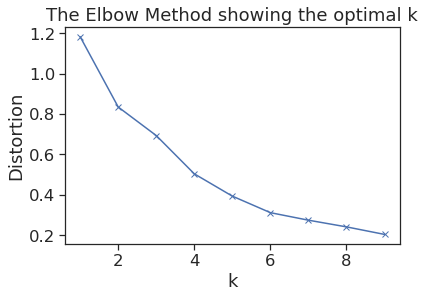

In [51]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [53]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:29]

array([0, 2, 1, 1, 2, 0, 0, 1, 2, 3, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0,
       1, 0, 2, 2, 0, 0], dtype=int32)

Here the cluster has been assigned. Add the cluster into the main dataframe to explore relationship

In [54]:
Gyeonggi_Jp_2.insert(0, 'Kmeans-Cluster Labels', kmeans.labels_)

In [55]:
Gyeonggi_Jp_2.head()

,Kmeans-Cluster Labels,City,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label
1,0,Ansan,689326.0,4624.5,1.0,10,0
2,2,Anseong,182784.0,330.3,1.0,32,2
3,1,Anyang,598392.0,10235.9,6.0,27,3
6,1,Bucheon,851245.0,15940.9,6.0,29,3
16,2,Dongducheon,98062.0,1025.1,0.0,13,2


Explore the relationship between these 2 densities

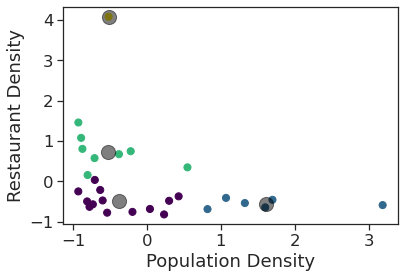

In [56]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Population Density')
plt.ylabel('Restaurant Density')
plt.show()

There are basically 4 clusters
- Group 1 - the purple dots, has low population density, and low restaurant density
- Group 2 - the green dots, has low population density, and relatively high restaurant density
- Group 3 - the blue dots,  has high population density, and low restaurant density
- Group 4 - the single outier, has very high restaurant density as compared to its population density

In [57]:
Gyeonggi_Jp_2['Number of restaurants per 1000 people'] = Gyeonggi_Jp_2['Number of Restaurants']/(Gyeonggi_Jp_2['Population']/1000)
Gyeonggi_Jp_2['Number of Japanese restaurants per 1000 people'] = Gyeonggi_Jp_2['Number of Japanese Restaurants']/(Gyeonggi_Jp_2['Population']/1000)

In [58]:
Gyeonggi_Jp_2.head()

,Kmeans-Cluster Labels,City,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label,Number of restaurants per 1000 people,Number of Japanese restaurants per 1000 people
1,0,Ansan,689326.0,4624.5,1.0,10,0,0.014507,0.001451
2,2,Anseong,182784.0,330.3,1.0,32,2,0.175070,0.005471
3,1,Anyang,598392.0,10235.9,6.0,27,3,0.045121,0.010027
6,1,Bucheon,851245.0,15940.9,6.0,29,3,0.034068,0.007048
16,2,Dongducheon,98062.0,1025.1,0.0,13,2,0.132569,0.000000


In [60]:
cluster0 = Gyeonggi_Jp_2[Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 0]

print('Cluster 0 (n={}) are cities with medium-low numbers of Restaurant per City (range: {} - {})\n\
with modium-low Population Density (median density={})'.format(cluster0.count()[0], 
                                                        cluster0['Number of restaurants per 1000 people'].min(),
                                                        cluster0['Number of restaurants per 1000 people'].max(),
                                                        cluster0['Density'].median()))
Gyeonggi_Jp_2[(Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 0)].sort_values(by='Density', ascending=False)

Cluster 0 (n=13) are cities with medium-low numbers of Restaurant per City (range: 0.014506924154899133 - 0.08683846562785269)
with modium-low Population Density (median density=1444.1)


,Kmeans-Cluster Labels,City,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label,Number of restaurants per 1000 people,Number of Japanese restaurants per 1000 people
74,0,Uijeongbu,438753.0,5377.5,2.0,23,2,0.052421,0.004558
55,0,Osan,208873.0,4884.8,0.0,9,2,0.043088,0.000000
1,0,Ansan,689326.0,4624.5,1.0,10,0,0.014507,0.001451
25,0,Goyang,1040648.0,3893.0,8.0,27,3,0.025945,0.007688
68,0,Siheung,403398.0,2987.7,0.0,8,2,0.019832,0.000000
84,0,Yongin,991622.0,1676.8,1.0,18,0,0.018152,0.001008
49,0,Namyangju,662183.0,1444.1,4.0,29,3,0.043795,0.006041
23,0,Gimpo,364808.0,1318.7,9.0,24,1,0.065788,0.024671
59,0,Pyeongtaek,472141.0,1038.5,1.0,41,2,0.086838,0.002118
39,0,Hwaseong,644498.0,937.4,5.0,23,3,0.035687,0.007758


In [61]:
cluster1 = Gyeonggi_Jp_2[Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 1]

print('Cluster 1 (n={}) are cities with low numbers of Restaurant per City (range: {} - {})\n\
with high Population Density (median density={})'.format(cluster1.count()[0], 
                                                        cluster1['Number of restaurants per 1000 people'].min(),
                                                        cluster1['Number of restaurants per 1000 people'].max(),
                                                        cluster1['Density'].median()))
Gyeonggi_Jp_2[(Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 1)].sort_values(by='Density', ascending=False)

Cluster 1 (n=6) are cities with low numbers of Restaurant per City (range: 0.025647470389995434 - 0.049168525119848275)
with high Population Density (median density=9334.85)


,Kmeans-Cluster Labels,City,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label,Number of restaurants per 1000 people,Number of Japanese restaurants per 1000 people
6,1,Bucheon,851245.0,15940.9,6.0,29,3,0.034068,0.007048
3,1,Anyang,598392.0,10235.9,6.0,27,3,0.045121,0.010027
71,1,Suwon,1194276.0,9862.7,6.0,35,3,0.029306,0.005024
33,1,Gwangmyeong,339071.0,8807.0,3.0,13,2,0.038340,0.008848
27,1,Gunpo,284735.0,7831.0,3.0,14,2,0.049169,0.010536
65,1,Seongnam,974755.0,6873.2,4.0,25,3,0.025647,0.004104


In [62]:
cluster2 = Gyeonggi_Jp_2[Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 2]

print('Cluster 2 (n={}) are cities with high numbers of Restaurant per City (range: {} - {})\n\
with low Population Density (median density={})'.format(cluster2.count()[0], 
                                                        cluster2['Number of restaurants per 1000 people'].min(),
                                                        cluster2['Number of restaurants per 1000 people'].max(),
                                                        cluster2['Density'].median()))
Gyeonggi_Jp_2[(Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 2)].sort_values(by='Density', ascending=False)

Cluster 2 (n=8) are cities with high numbers of Restaurant per City (range: 0.09709821970414172 - 0.20727939318957644)
with low Population Density (median density=845.0)


,Kmeans-Cluster Labels,City,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label,Number of restaurants per 1000 people,Number of Japanese restaurants per 1000 people
29,2,Guri,194298.0,5834.8,0.0,22,2,0.113228,0.000000
75,2,Uiwang,156410.0,2896.5,1.0,23,2,0.147049,0.006393
38,2,Hanam,213028.0,2288.9,7.0,30,1,0.140827,0.032860
16,2,Dongducheon,98062.0,1025.1,0.0,13,2,0.132569,0.000000
78,2,Yangju,205977.0,664.9,3.0,20,2,0.097098,0.014565
40,2,Icheon,210565.0,396.5,2.0,32,2,0.151972,0.009498
2,2,Anseong,182784.0,330.3,1.0,32,2,0.175070,0.005471
57,2,Pocheon,154381.0,186.8,2.0,32,2,0.207279,0.012955


In [63]:
cluster3 = Gyeonggi_Jp_2[Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 3]

print('Cluster 3 (n={}) are cities with very high numbers of Restaurant per City (range: {} - {})\n\
with medium Population Density (median density={})'.format(cluster3.count()[0], 
                                                        cluster3['Number of restaurants per 1000 people'].min(),
                                                        cluster3['Number of restaurants per 1000 people'].max(),
                                                        cluster3['Density'].median()))
Gyeonggi_Jp_2[(Gyeonggi_Jp_2['Kmeans-Cluster Labels'] == 3)].sort_values(by='Density', ascending=False)

Cluster 3 (n=1) are cities with very high numbers of Restaurant per City (range: 0.42905496670851273 - 0.42905496670851273)
with medium Population Density (median density=1754.9)


,Kmeans-Cluster Labels,City,Population,Density,Number of Japanese Restaurants,Number of Restaurants,Cluster Label,Number of restaurants per 1000 people,Number of Japanese restaurants per 1000 people
30,3,Gwacheon,62929.0,1754.9,4.0,27,1,0.429055,0.063564


It needs to be clear that the density analysis result should not be used directly to "determine" the ideal location of "Japanese restaurant", because first it is not directly evaluating "Japanese density", secondly a very high population density sometimes maybe a reason of a lower restaurant density (per population), because with limited space you can only built that many restaurants. 

However this data has provided supporting evidence to the clustering analysis in the previous part. The 3 cities we found before, 1, 84 and 68 are all in the same cluster, which has relatively high population density, and relatively low restaurant density. 

# 4. Results

When combining the cluster analysis based on ‘City Population’ and ‘number of Japanese restaurant’ with  the analysis of ‘population’ and ‘restaurant’  densities, we can identify 3 target cities of the biggest interest to setup the new Japanese restaurant:

1.	Ansan, original index 1
2.	Yongin, original index 84
3.	Siheung, original index 68 

There 3 cities meet the objectives such as 

- High Population
- Low number of Japanese Restaurants
- Also a higher population density vs. a lower restaurant density. 

These factors make it more possible to achieve success when setting up a Japanese restaurant inside the city. 

Among these 3 objects, Yongin needs to be further confirmed of its Japanese restaurant number because it reached FourSquare limit of 100 venues. Ansan and Siheung are safer choices, because they did not reach FourSquare limit. So the data from Foursquare is more trustable.  